In [1]:
# TODO - запилить в зависимости sentencepiece
# !pip install sentencepiece

In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

from rapidfuzz import fuzz
from pyjarowinkler import distance

from utils.autocomplete.markup_yolo import  get_dates_and_numbers
from utils.autocomplete import yolo_utils as yolo
from utils.operate_data import load_dataset

from transformers import AutoTokenizer, AutoModel, VisionEncoderDecoderModel, TrOCRProcessor
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import default_data_collator

from tqdm import tqdm
tqdm.pandas()

%matplotlib inline

/opt/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/venv/lib/python3.10/site-packages/pydantic/_internal/_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
  warnings.warn(message, UserWarning)


In [2]:
# натренированная модель
model = VisionEncoderDecoderModel.from_pretrained('/local_data/models/microsoft-trocr-base-handwritten/')
processor = TrOCRProcessor.from_pretrained('/local_data/models/microsoft-trocr-base-handwritten/processor/')

# полная версия модели с hugingface
# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

# processor.save_pretrained('/local_data/models/microsoft-trocr-base-handwritten-small/processor/')

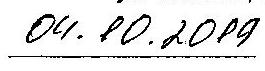

In [3]:
PATH_TO_DATES_IMAGES = Path('/local_data/yolov_markup/handwrites_images/dates/') # путь к  изображениям дат 
PATH_TO_DETECT_PDF = Path('/data/docs/mer/vh_full/')

image = Image.open(PATH_TO_DATES_IMAGES / 'fdb6d1ac-3b4e-4d96-b770-e86e057a0355.jpeg').convert("RGB")
image

###  research model microsoft/trocr-base-handwritten

In [4]:
pixel_values = processor(image, return_tensors="pt").pixel_values

In [5]:
generated_ids  = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

'04.10.2019'

In [6]:
path_to_dates = [path for path in PATH_TO_DATES_IMAGES.iterdir()]

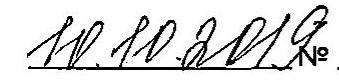

10.10.2019 cb97bbbe-6bca-41da-be07-21519fdb744f


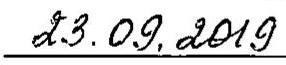

23.09.2019 be318060-d1f7-486f-bc05-3802c6545282


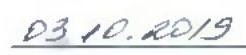

03.10.2019 33ab9684-2fd7-4a7b-b7a2-7aa095eec261


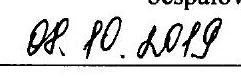

08.10.2019 aeb5d8ef-026d-4016-93ef-97efd037347a


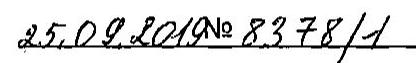

25.09.2019 0700140e-f615-48ee-be01-323743a032e6


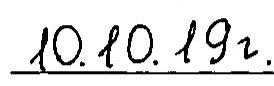

10.10.2019 572e1d0c-56b7-4ded-9d33-8a4741939a84


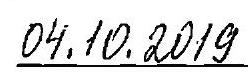

04.10.2019 a9c93320-bf77-4399-a406-3f9de04490fb


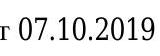

07.10.2019 ba9e8188-b933-4256-bdd8-9b9a16d6ebbc


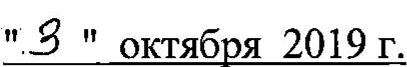

03.10.2019 ecd5dd64-ebf8-4fd5-a6d3-4aedd4060b10


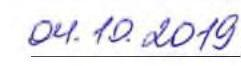

04.10.2019 026d46f2-a053-4274-ab0b-6c7300f8495c


In [7]:
paths = path_to_dates[10:20]
# paths = path_to_dates
dates, doc_id, images = [], [], []
for path in paths:
    image = Image.open(path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    generated_ids  = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    display(image)
    dates.append(generated_text)
    doc_id.append(path.stem)
    images.append(image)
    print(generated_text, path.stem)  

In [9]:
dfs = {'doc_id': doc_id, 'predict_dates': dates, 'image': images}
df_no_train = pd.DataFrame(dfs)
df_no_train

,doc_id,predict_dates,image
0,cb97bbbe-6bca-41da-be07-21519fdb744f,10.10.2019,<PIL.Image.Image image mode=RGB size=339x83 at...
1,be318060-d1f7-486f-bc05-3802c6545282,23.09.2019,<PIL.Image.Image image mode=RGB size=286x65 at...
2,33ab9684-2fd7-4a7b-b7a2-7aa095eec261,03.10.2019,<PIL.Image.Image image mode=RGB size=246x55 at...
3,aeb5d8ef-026d-4016-93ef-97efd037347a,08.10.2019,<PIL.Image.Image image mode=RGB size=241x78 at...
4,0700140e-f615-48ee-be01-323743a032e6,25.09.2019,<PIL.Image.Image image mode=RGB size=416x63 at...
5,572e1d0c-56b7-4ded-9d33-8a4741939a84,10.10.2019,<PIL.Image.Image image mode=RGB size=274x86 at...
6,a9c93320-bf77-4399-a406-3f9de04490fb,04.10.2019,<PIL.Image.Image image mode=RGB size=248x77 at...
7,ba9e8188-b933-4256-bdd8-9b9a16d6ebbc,07.10.2019,<PIL.Image.Image image mode=RGB size=160x56 at...
8,ecd5dd64-ebf8-4fd5-a6d3-4aedd4060b10,03.10.2019,<PIL.Image.Image image mode=RGB size=407x67 at...
9,026d46f2-a053-4274-ab0b-6c7300f8495c,04.10.2019,<PIL.Image.Image image mode=RGB size=241x66 at...


### Create dataframe with images and doc_id

In [11]:
# df_meta = yolo.get_meta(PATH_TO_DETECT_PDF)

In [4]:
df_meta, _ = load_dataset('/local_data/meta_data/', df_name = 'meta.pickle', files_df_name=None)
df_meta.reset_index(inplace=True)

In [19]:
df_meta = df_meta[['doc_id', 'out_reg_date']]

In [21]:
# paths = path_to_dates[:10]
paths = path_to_dates
doc_id, images = [], []
for path in paths:
    images.append(Image.open(path).convert("RGB"))
    doc_id.append(path.stem)
img = {'doc_id': doc_id, 'image': images}    
df_images = pd.DataFrame(img)


# создание небольшого датафрейма с перемешанными данными
# df_images = df_images.sample(frac=1)
# df_images = df_images.head(200)
df_images

,doc_id,image
0,693270e8-cf4b-4f25-ac5a-49c181196947,<PIL.Image.Image image mode=RGB size=204x57 at...
1,d69f56c0-7762-48bb-b7de-ffaca50f30dd,<PIL.Image.Image image mode=RGB size=297x79 at...
2,59f3d0dd-b3f9-4db4-8860-63f503de165b,<PIL.Image.Image image mode=RGB size=199x57 at...
3,303c2349-fb22-43cd-b03a-61b677c873c7,<PIL.Image.Image image mode=RGB size=203x62 at...
4,39d89bd6-10f6-462e-82ee-6512035977eb,<PIL.Image.Image image mode=RGB size=464x84 at...
...,...,...
1304,5c870223-5a85-45ed-b107-cd350581e5e7,<PIL.Image.Image image mode=RGB size=345x77 at...
1305,3ab030f1-ead1-45dc-abec-65ebcdd7f11e,<PIL.Image.Image image mode=RGB size=183x54 at...
1306,84acf1b0-b484-4f3c-bf73-c0f0e9cb5343,<PIL.Image.Image image mode=RGB size=453x84 at...
1307,2e81dd13-6298-4d79-85e4-c6766131280e,<PIL.Image.Image image mode=RGB size=459x74 at...


In [22]:
df_images = df_images.merge(df_meta, on='doc_id')
df_images['out_reg_date'] = df_images['out_reg_date'].apply(lambda row: row.date())

In [23]:
df_images

,doc_id,image,out_reg_date
0,693270e8-cf4b-4f25-ac5a-49c181196947,<PIL.Image.Image image mode=RGB size=204x57 at...,2019-10-04
1,d69f56c0-7762-48bb-b7de-ffaca50f30dd,<PIL.Image.Image image mode=RGB size=297x79 at...,2019-09-20
2,59f3d0dd-b3f9-4db4-8860-63f503de165b,<PIL.Image.Image image mode=RGB size=199x57 at...,2019-10-09
3,303c2349-fb22-43cd-b03a-61b677c873c7,<PIL.Image.Image image mode=RGB size=203x62 at...,2019-10-07
4,39d89bd6-10f6-462e-82ee-6512035977eb,<PIL.Image.Image image mode=RGB size=464x84 at...,2019-10-14
...,...,...,...
1304,5c870223-5a85-45ed-b107-cd350581e5e7,<PIL.Image.Image image mode=RGB size=345x77 at...,2019-10-08
1305,3ab030f1-ead1-45dc-abec-65ebcdd7f11e,<PIL.Image.Image image mode=RGB size=183x54 at...,2019-10-09
1306,84acf1b0-b484-4f3c-bf73-c0f0e9cb5343,<PIL.Image.Image image mode=RGB size=453x84 at...,2019-09-17
1307,2e81dd13-6298-4d79-85e4-c6766131280e,<PIL.Image.Image image mode=RGB size=459x74 at...,2019-10-02


In [ ]:
# df_images['month'] = df_images.out_reg_date.apply(lambda row: row.month)

In [ ]:
# df_images['month'].value_counts()

### Train model

In [24]:
len(df_images)

1309

In [25]:
train_size = int(len(df_images)*0.85)
test_size = len(df_images) - train_size

train_df = df_images.head(train_size)
test_df = df_images.tail(test_size)

In [26]:
# train_df = df_images[df_images.month == 10]
# test_df = df_images[df_images.month != 10]

In [27]:
train_df.shape, test_df.shape

((1112, 3), (197, 3))

In [28]:
train_df.dropna(inplace=True)
train_df['out_reg_date'] = train_df['out_reg_date'].apply(lambda row: row.strftime("%d.%m.%Y"))

test_df.dropna(inplace=True)
test_df['out_reg_date'] = test_df['out_reg_date'].apply(lambda row: row.strftime("%d.%m.%Y"))

/tmp/ipykernel_31/3088856043.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(inplace=True)
/tmp/ipykernel_31/3088856043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['out_reg_date'] = train_df['out_reg_date'].apply(lambda row: row.strftime("%d.%m.%Y"))
/tmp/ipykernel_31/3088856043.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.dropn

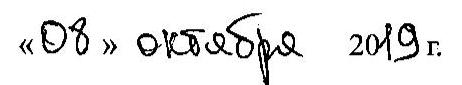

In [29]:
test_df['image'].iloc[0]

In [30]:
class IAMDataset(Dataset):
    def __init__(self,df, processor, max_target_length=32):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        image = self.df['image'].iloc[idx]
        text = self.df['out_reg_date'].iloc[idx]
        # prepare image (i.e. resize + normalize)
#         image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [31]:
train_dataset = IAMDataset(df=train_df, processor=processor)
eval_dataset = IAMDataset(df=test_df, processor=processor)

In [32]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 1087
Number of validation examples: 194


In [33]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([32])


In [34]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

04.10.2019


In [35]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 32
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [36]:
# from datasets import load_metric

# cer_metric = load_metric("cer")

In [37]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    
    label_date = ''.join(list(filter(None,label_str)))
    predict_date = ''.join(list(filter(None,pred_str)))


    sim = fuzz.token_sort_ratio(predict_date, label_date)
    
    return {'similarity': round(sim,3)}#, 'predict': predict_date, 'label': label_date}

#     cer = cer_metric.compute(predictions=pred_str, references=label_str)
#     return {"cer": cer}
    

In [29]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=False, 
    output_dir="./",
    num_train_epochs=40,
    save_total_limit=3,
#     logging_steps=2,
#     save_steps=1000,
#     eval_steps=200,
)

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

/opt/venv/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [30]:
trainer.train()

Trainer is attempting to log a value of "{'vocab_size': 64044, 'd_model': 256, 'decoder_layers': 6, 'decoder_attention_heads': 8, 'decoder_ffn_dim': 1024, 'activation_function': 'relu', 'max_position_embeddings': 512, 'dropout': 0.1, 'attention_dropout': 0.0, 'activation_dropout': 0.0, 'init_std': 0.02, 'decoder_layerdrop': 0.0, 'use_cache': False, 'scale_embedding': True, 'use_learned_position_embeddings': True, 'layernorm_embedding': True, 'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': None, 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': False, 'is_encoder_decoder': False, 'is_decoder': True, 'cross_attention_hidden_size': 384, 'add_cross_attention': True, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0

Epoch,Training Loss,Validation Loss,Similarity
1,No log,0.833268,85.155000
2,No log,0.725155,85.773000
3,No log,0.766924,85.309000
4,0.432800,0.829281,85.876000
5,0.432800,0.873769,85.052000
6,0.432800,0.965194,86.134000
7,0.432800,0.891986,84.948000
8,0.321000,1.097220,84.948000
9,0.321000,1.111702,85.412000
10,0.321000,1.259752,85.258000


TrainOutput(global_step=5440, training_loss=0.10802988542093184, metrics={'train_runtime': 17799.6857, 'train_samples_per_second': 2.443, 'train_steps_per_second': 0.306, 'total_flos': 5.201281408995164e+18, 'train_loss': 0.10802988542093184, 'epoch': 40.0})

In [38]:
# model.save_pretrained('/local_data/models/microsoft-trocr-base-handwritten/')

model.save_pretrained('/local_data/models/microsoft-trocr-base-handwritten-small/')

# predict

In [38]:
def predict_date(image, processor, model):
    pixel_values = processor(image, return_tensors="pt").pixel_values
    generated_ids  = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return generated_text

In [39]:
test_df['predict_date'] = test_df.image.progress_apply(lambda row: predict_date(row, processor, model))
test_df['sim'] = test_df.apply(lambda row: fuzz.token_sort_ratio(row['out_reg_date'], row['predict_date']), axis=1)

# test_df['predict_date'] = pd.to_datetime(test_df['predict_date'],dayfirst=True)
# test_df['out_reg_date'] = pd.to_datetime(test_df['out_reg_date'],dayfirst=True)

test_df['target'] = test_df['predict_date'] == test_df['out_reg_date']

100%|██████████| 194/194 [05:15<00:00,  1.63s/it]
/tmp/ipykernel_31/1570476767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predict_date'] = test_df.image.progress_apply(lambda row: predict_date(row, processor, model))
/tmp/ipykernel_31/1570476767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['sim'] = test_df.apply(lambda row: fuzz.token_sort_ratio(row['out_reg_date'], row['predict_date']), axis=1)
/tmp/ipykernel_31/1570476767.py:7: SettingWithCopyWarning: 
A value is trying to

In [40]:
test_df.target.value_counts()

target
True     176
False     18
Name: count, dtype: int64

In [41]:
len(test_df[test_df.sim >= 90])/len(test_df)

0.9690721649484536

In [42]:
len(test_df[test_df.sim == 100])/len(test_df)

0.9072164948453608

In [1]:
test_df

NameError: name 'test_df' is not defined

In [44]:
test_df.target.value_counts()

target
True     176
False     18
Name: count, dtype: int64

In [45]:
len(test_df[test_df.sim >= 90])/len(test_df)

0.9690721649484536

In [46]:
len(test_df[test_df.sim == 100])/len(test_df)

0.9072164948453608

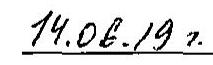

In [47]:
test_df.loc[1184].image

In [48]:
test_df[test_df.target == False]

,doc_id,image,out_reg_date,predict_date,sim,target
1112,7c1cce7e-97ae-48f3-9e56-859d26d13f29,<PIL.Image.Image image mode=RGB size=462x85 at...,08.10.2019,01.10.2019,90.0,False
1127,65c52b59-84e2-4bef-a681-ade6af348fcb,<PIL.Image.Image image mode=RGB size=350x74 at...,04.10.2019,30.09.2019,80.0,False
1135,7c45c577-c0ba-4ff2-bee5-3cac79c3f282,<PIL.Image.Image image mode=RGB size=254x78 at...,19.08.2019,19.09.2019,90.0,False
1139,5f653d62-314b-4128-a7bb-57eea0369e4a,<PIL.Image.Image image mode=RGB size=188x46 at...,11.10.2019,20.09.2019,70.0,False
1141,41f5dcc0-23a3-452b-b209-f947cb4c16a6,<PIL.Image.Image image mode=RGB size=408x52 at...,03.10.2019,24.09.2019,70.0,False
1158,a407ac93-5a97-45c1-81d6-ab59c6f5aed2,<PIL.Image.Image image mode=RGB size=328x79 at...,01.10.2019,11.10.2019,90.0,False
1173,3c19a486-2c7b-4bd8-b919-4d91e3695799,<PIL.Image.Image image mode=RGB size=207x56 at...,08.10.2019,10.10.2019,90.0,False
1177,6b51049a-a813-4a2f-adc9-0eb74ed4a8c0,<PIL.Image.Image image mode=RGB size=247x72 at...,02.10.2019,08.10.2019,90.0,False
1184,afa58aa4-420a-45e9-8190-6afb2438fb60,<PIL.Image.Image image mode=RGB size=213x65 at...,14.06.2019,14.10.2019,90.0,False
1192,943a1f17-b0bf-489d-83d8-0174ffc8c127,<PIL.Image.Image image mode=RGB size=196x76 at...,04.07.2019,04.10.2019,90.0,False


In [ ]:
'/data/docs/mer/vh_full/41f5dcc0-23a3-452b-b209-f947cb4c16a6/225c8351-7c6a-49ed-b40d-94b49f21fab7.pdf'

In [124]:
x = Path('41f5dcc0-23a3-452b-b209-f947cb4c16a6')

In [196]:
yolo.show_pdf(x)

в папке 3 pdf, какой открыть?2


In [178]:
df_dates = yolo.get_meta(PATH_TO_DETECT_PDF)

100%|██████████| 9528/9528 [00:07<00:00, 1213.69it/s]


In [179]:
df_dates = df_dates[['doc_id', 'reg_date', 'out_reg_date']]
df_dates.dropna(inplace=True)

In [180]:
df_dates['reg_date'] = df_dates['reg_date'].apply(lambda row: row.date())
df_dates['out_reg_date'] = df_dates['out_reg_date'].apply(lambda row: row.date())

In [181]:
df_dates['difference'] = df_dates['reg_date'] - df_dates['out_reg_date']
df_dates['difference'] = df_dates['difference'].apply(lambda row: row.days)

In [183]:
df_dates['difference'].value_counts()

difference
 0      2850
 1      2439
 3       864
 2       784
 4       427
        ... 
 76        1
 70        1
-25        1
-26        1
 147       1
Name: count, Length: 80, dtype: int64

<Axes: >

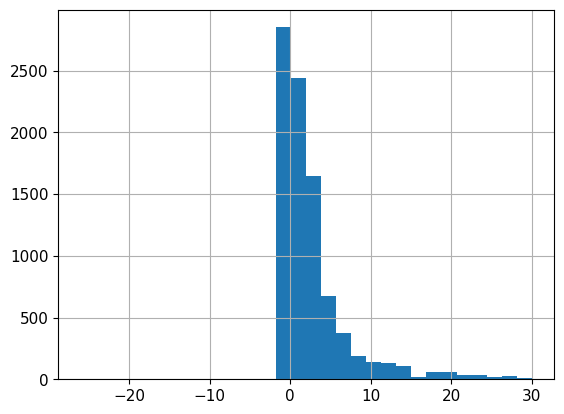

In [193]:
df_dates[df_dates['difference'] <= 30]['difference'].hist(bins=30)

In [ ]:
# tokenizer = VisionEncoderDecoderModel.from_pretrained("DunnBC22/trocr-base-handwritten-OCR-handwriting_recognition_v2")
# model = VisionEncoderDecoderModel.from_pretrained("DunnBC22/trocr-base-handwritten-OCR-handwriting_recognition_v2")

# tokenizer = VisionEncoderDecoderModel.from_pretrained("jinhybr/OCR-Donut-CORD")
# model = VisionEncoderDecoderModel.from_pretrained("jinhybr/OCR-Donut-CORD")

# tokenizer = AutoTokenizer.from_pretrained("DunnBC22/trocr-large-printed-cmc7_tesseract_MICR_ocr")
# model = VisionEncoderDecoderModel.from_pretrained("DunnBC22/trocr-large-printed-cmc7_tesseract_MICR_ocr")

In [9]:
df_dates = df_meta[['reg_date', 'out_reg_date']]

In [10]:
df_dates['out_reg_date'] = df_dates['out_reg_date'].apply(lambda row: row.date())
df_dates['reg_date'] = df_dates['reg_date'].apply(lambda row: row.date())

/tmp/ipykernel_686/1209886672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dates['out_reg_date'] = df_dates['out_reg_date'].apply(lambda row: row.date())
/tmp/ipykernel_686/1209886672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dates['reg_date'] = df_dates['reg_date'].apply(lambda row: row.date())


In [35]:
df_dates['reg_date'] = df_dates['reg_date'].apply(pd.Timestamp)
df_dates['out_reg_date'] = df_dates['out_reg_date'].apply(pd.Timestamp)
df_dates['dif'] = (df_dates['reg_date'] - df_dates['out_reg_date']).dt.days

/tmp/ipykernel_686/210507290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dates['reg_date'] = df_dates['reg_date'].apply(pd.Timestamp)
/tmp/ipykernel_686/210507290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dates['out_reg_date'] = df_dates['out_reg_date'].apply(pd.Timestamp)
/tmp/ipykernel_686/210507290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [36]:
df_dates.dif.min(), df_dates.dif.mean(), df_dates.dif.max()

(-26.0, 3.185751208000899, 267.0)

<Axes: >

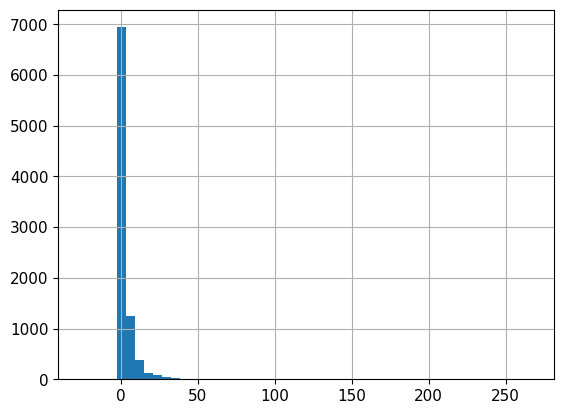

In [38]:
df_dates.dif.hist(bins=50)

In [39]:
df_dates.shape,

(9528, 4)

In [51]:
for i in range(int(df_dates.dif.max())):
    if not (df_tt:= df_dates[df_dates.dif == i]).empty:
        print(f'{i}: {df_tt.shape[0]}')

0: 2850
1: 2439
2: 784
3: 864
4: 427
5: 251
6: 175
7: 200
8: 123
9: 69
10: 71
11: 67
12: 58
13: 74
14: 69
15: 40
16: 17
17: 23
18: 33
19: 24
20: 31
21: 21
22: 12
23: 17
24: 16
25: 10
26: 9
27: 11
28: 12
29: 4
30: 4
31: 4
32: 5
33: 9
34: 3
35: 3
36: 3
37: 4
38: 4
39: 3
40: 2
41: 3
42: 1
44: 1
45: 3
46: 5
47: 1
48: 4
49: 1
52: 1
53: 1
56: 1
62: 2
63: 1
64: 1
66: 2
69: 1
70: 1
72: 1
74: 1
76: 1
95: 1
97: 1
99: 1
103: 1
104: 1
107: 1
110: 1
135: 1
145: 1
147: 1
174: 1
243: 1
